In [1]:
import copy
import gzip
import io
import os
from io import StringIO
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import pathlib
from pathlib import Path
from shapely import wkt
from datetime import datetime
import xml.etree.ElementTree as ET
import lxml.etree as etree
from xml.dom import minidom
import numpy as np

In [2]:
# read the files
BASE_DIR = Path.cwd().parent # G:\road_ntwrk
shp = BASE_DIR / "road_ntwrk" / "rd_ntwrk_2016.shp"
gpdSFRdNtwrk = gpd.read_file(shp)

In [3]:
gpdSFRdNtwrk=gpdSFRdNtwrk[gpdSFRdNtwrk['MTYPE']=='SF']

In [8]:
gpdSFRdNtwrk.groupby('FT').agg({'CAP':'max','SPEED':'max'})

,CAP,SPEED
FT,,
1,1750,40
2,1900,60
3,1450,60
4,700,30
5,1400,30
7,950,35
9,300,25
11,350,30
12,800,35


In [4]:
gpdSFRdNtwrk=gpdSFRdNtwrk[gpdSFRdNtwrk['FT']!=9]

In [5]:
shp = BASE_DIR / "road_ntwrk" / "2016_PM.shp"
rd_network_2016 = gpd.read_file(shp)

In [6]:
rd_network_2016=rd_network_2016[rd_network_2016['FT'].isin([1,2,3,5,7,10])]

In [7]:
outside_sf_fwy_arterial=rd_network_2016[rd_network_2016['MTYPE']=='MTC']

In [8]:
len(gpdSFRdNtwrk)

26296

In [9]:
len(outside_sf_fwy_arterial)

14899

In [10]:
# read the files
# BASE_DIR = Path.cwd().parent # G:\road_ntwrk
# shp = BASE_DIR / "road_ntwrk" / "rd_ntwrk_2016.shp"

gpdSFRdNtwrk=gpdSFRdNtwrk.to_crs('EPSG:26910')
from shapely.geometry import Point, LineString
gpdSFRdNtwrk['first'] = None
gpdSFRdNtwrk['last'] = None
for index, row in tqdm(gpdSFRdNtwrk.iterrows()):
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    gpdSFRdNtwrk.at[index,'first'] = Point(first_coord)
    gpdSFRdNtwrk.at[index,'last'] = Point(last_coord)

gpdSFRdNtwrk["length_m"] = gpdSFRdNtwrk["geometry"].to_crs('EPSG:26910').length  # get length in meters of the feature
#gpdSFRdNtwrk["geometry"] = gpdSFRdNtwrk["geometry"].to_crs('EPSG:4326')  # re-project to EPSG:4326/WGS1984
#gpdSFRdNtwrk["geometry"] = gpdSFRdNtwrk["geometry"].to_crs('EPSG:26910') # re-project to local PCS

# get the max of the lanes
gpdSFRdNtwrk['lane']= gpdSFRdNtwrk[['LANE_AM','LANE_PM','LANE_OP',]].max(axis=1)

from shapely import wkt
gpdSFNode_A = gpdSFRdNtwrk[["first","A"]]
gpdSFNode_A = gpd.GeoDataFrame(gpdSFNode_A, geometry='first')

# gpdSFNode_A.drop_duplicates()
gpdSFNode_B = gpdSFRdNtwrk[["last","B"]]
gpdSFNode_B = gpd.GeoDataFrame(gpdSFNode_B, geometry='last')

G = gpdSFNode_A["first"].apply(lambda geom: geom.wkb) # drop duplicate features
gpdSFNode_A = gpdSFNode_A.loc[G.drop_duplicates().index]

G = gpdSFNode_B["last"].apply(lambda geom: geom.wkb) # drop duplicate features
gpdSFNode_B = gpdSFNode_B.loc[G.drop_duplicates().index]

gpdSFRdNtwrk["segment_id"] = gpdSFRdNtwrk[['A', 'B']].astype(str).agg('_'.join, axis=1)

gpdSFNode_A["X"] = gpdSFNode_A["first"].x
gpdSFNode_A["Y"] = gpdSFNode_A["first"].y

gpdSFNode_B["X"] = gpdSFNode_B["last"].x
gpdSFNode_B["Y"] = gpdSFNode_B["last"].y

26296it [00:04, 5728.34it/s]


In [11]:
# read the files
# BASE_DIR = Path.cwd().parent # G:\road_ntwrk
# shp = BASE_DIR / "road_ntwrk" / "rd_ntwrk_2016.shp"


outside_sf_fwy_arterial=outside_sf_fwy_arterial.to_crs('EPSG:26910')
from shapely.geometry import Point, LineString
outside_sf_fwy_arterial['first'] = None
outside_sf_fwy_arterial['last'] = None
for index, row in tqdm(outside_sf_fwy_arterial.iterrows()):
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    outside_sf_fwy_arterial.at[index,'first'] = Point(first_coord)
    outside_sf_fwy_arterial.at[index,'last'] = Point(last_coord)

outside_sf_fwy_arterial["length_m"] = outside_sf_fwy_arterial["geometry"].to_crs('EPSG:26910').length  # get length in meters of the feature
#gpdSFRdNtwrk["geometry"] = gpdSFRdNtwrk["geometry"].to_crs('EPSG:4326')  # re-project to EPSG:4326/WGS1984
#gpdSFRdNtwrk["geometry"] = gpdSFRdNtwrk["geometry"].to_crs('EPSG:26910') # re-project to local PCS

# get the max of the lanes
outside_sf_fwy_arterial['lane']= outside_sf_fwy_arterial[['LANE_AM','LANE_PM','LANE_OP',]].max(axis=1)

from shapely import wkt
outside_sf_fwy_arterial_Node_A = outside_sf_fwy_arterial[["first","A"]]
outside_sf_fwy_arterial_Node_A = gpd.GeoDataFrame(outside_sf_fwy_arterial_Node_A, geometry='first')

# gpdSFNode_A.drop_duplicates()
outside_sf_fwy_arterial_Node_B = outside_sf_fwy_arterial[["last","B"]]
outside_sf_fwy_arterial_Node_B = gpd.GeoDataFrame(outside_sf_fwy_arterial_Node_B, geometry='last')

G = outside_sf_fwy_arterial_Node_A["first"].apply(lambda geom: geom.wkb) # drop duplicate features
outside_sf_fwy_arterial_Node_A = outside_sf_fwy_arterial_Node_A.loc[G.drop_duplicates().index]

G = outside_sf_fwy_arterial_Node_B["last"].apply(lambda geom: geom.wkb) # drop duplicate features
outside_sf_fwy_arterial_Node_B = outside_sf_fwy_arterial_Node_B.loc[G.drop_duplicates().index]

outside_sf_fwy_arterial["segment_id"] = outside_sf_fwy_arterial[['A', 'B']].astype(str).agg('_'.join, axis=1)

outside_sf_fwy_arterial_Node_A["X"] = outside_sf_fwy_arterial_Node_A["first"].x
outside_sf_fwy_arterial_Node_A["Y"] = outside_sf_fwy_arterial_Node_A["first"].y

outside_sf_fwy_arterial_Node_B["X"] = outside_sf_fwy_arterial_Node_B["last"].x
outside_sf_fwy_arterial_Node_B["Y"] = outside_sf_fwy_arterial_Node_B["last"].y

14899it [00:02, 5293.68it/s]


In [13]:
outside_sf_fwy_arterial['FT']=np.where(outside_sf_fwy_arterial['FT']==7,
                                      25,
                                      outside_sf_fwy_arterial['FT'])

In [14]:
SF_shell_network=gpdSFRdNtwrk.append(outside_sf_fwy_arterial)
len(SF_shell_network)

41195

In [15]:
def ffs(df):
    if df.FT==1:
        return df.SPEED/1.3
    elif df.FT==2:
        return df.SPEED/1.0
    elif df.FT==3:
        return df.SPEED/1.0
    elif df.FT==4:
        return df.SPEED/1.8
    elif df.FT==5:
        return df.SPEED/1.3
    elif df.FT==6:
        return df.SPEED/1.0
    elif df.FT==7:
        return df.SPEED/1.8
    elif df.FT==8:
        return df.SPEED/1.3
    elif df.FT==9:
        return df.SPEED/1.8
    elif df.FT==10:
        return df.SPEED/1.0
    elif df.FT==11:
        return df.SPEED/1.8
    elif df.FT==12:
        return df.SPEED/1.8
    elif df.FT==13:
        return df.SPEED/1.0
    elif df.FT==14:
        return df.SPEED/1.8
    else:
        return df.SPEED/1.8
    

In [16]:

SF_shell_network['FFS']=SF_shell_network.apply(ffs,axis=1)
SF_shell_network.head()

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,...,V17T_1,V18T_1,V19T_1,geometry,first,last,length_m,lane,segment_id,FFS
1,6956,40029,0,1,1900,3,2,HWY 101 NORTHBOUND,None,SF,...,0,0,0,"LINESTRING (553350.105 4173345.867, 553321.044...",POINT (553350.1049987555 4173345.866918292),POINT (553321.0443192082 4173587.894676579),243.766197,4,6956_40029,60.000000
5,6985,52492,0,1,700,3,4,ALANA,WY,SF,...,0,0,0,"LINESTRING (553233.987 4173488.293, 553213.008...",POINT (553233.9865038841 4173488.292556874),POINT (553213.0080131211 4173653.892292572),166.923244,1,6985_52492,16.666667
7,6986,50856,0,1,700,3,4,TUNNEL,AVE,SF,...,0,0,0,"LINESTRING (552787.287 4173442.609, 552771.047...",POINT (552787.2868845273 4173442.608694352),POINT (552771.0472341935 4173628.304658828),186.404714,1,6986_50856,16.666667
16,7678,51171,0,1,1450,3,3,SKYLINE,BLVD,SF,...,0,0,0,"LINESTRING (544554.127 4172454.863, 544230.365...",POINT (544554.1268992884 4172454.863459124),POINT (544230.3645094866 4173547.844602554),1139.925377,2,7678_51171,60.000000
17,7702,52234,0,1,1400,2,5,I-280 S ON-RAMP,None,SF,...,0,0,0,"LINESTRING (546770.121 4173200.868, 546735.465...",POINT (546770.1208839923 4173200.868387244),POINT (546735.4647272229 4173440.898428193),242.519009,1,7702_52234,23.076923


In [16]:
gpdSFRdNtwrk=gpdSFRdNtwrk.reset_index()
gpdSFRdNtwrk['LINK_ID']=gpdSFRdNtwrk.index+1
gpdSFRdNtwrk.drop(columns=['index'],inplace=True)

In [17]:
SF_shell_network=SF_shell_network.reset_index()
SF_shell_network['LINK_ID']=SF_shell_network.index+1
SF_shell_network.drop(columns=['index'],inplace=True)

In [18]:
SF_shell_network=SF_shell_network[SF_shell_network['FT']!=0]

In [24]:
SF_shell_network.drop(columns=['first','last']).to_file('../SF_CHAMP_Converted/BEAM_Network.shp')

<AxesSubplot:>

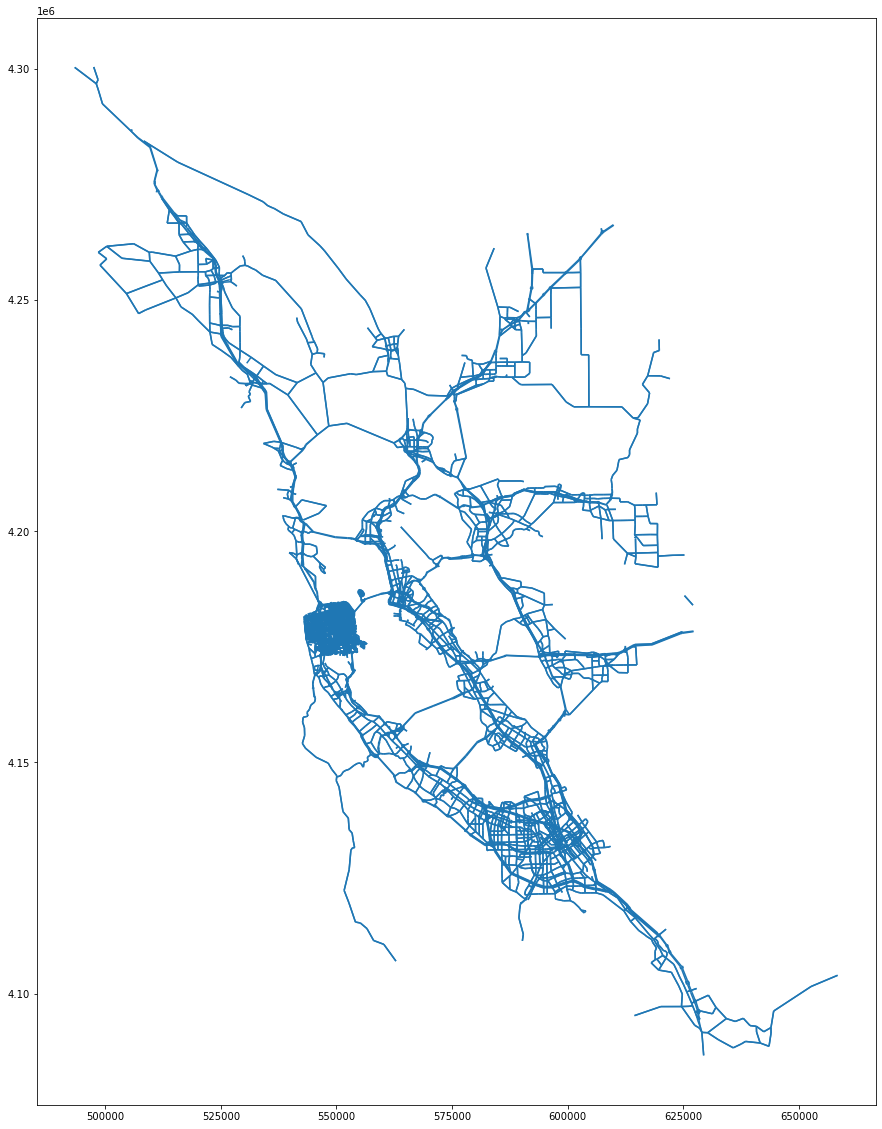

In [28]:
SF_shell_network.plot(figsize=[20,20])

In [21]:
SF_shell_network.to_file('../SF_CHAMP_Converted/BEAM_Network.shp')

ValueError: Invalid field type <class 'shapely.geometry.point.Point'>

In [30]:
SF_shell_network[SF_shell_network['TOLL']!=0].head()

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,SPEED,DISTANCE,TIME,LANE_AM,LANE_OP,LANE_PM,BUSLANE_AM,BUSLANE_OP,BUSLANE_PM,TOLLAM_DA,TOLLAM_SR2,TOLLAM_SR3,TOLLPM_DA,TOLLPM_SR2,TOLLPM_SR3,TOLLEA_DA,TOLLEA_SR2,TOLLEA_SR3,TOLLMD_DA,TOLLMD_SR2,TOLLMD_SR3,TOLLEV_DA,TOLLEV_SR2,TOLLEV_SR3,VALUETOLL_,PASSTHRU,BUSTPS_AM,BUSTPS_OP,BUSTPS_PM,TSVA,TSIN,BIKE_CLASS,PER_RISE,ONEWAY,PROJ,DTA_EDIT_F,TOLLTIME,PHASE,ACTION,AMBUSSAVE,...,VC_1,CSPD_1,VDT_1,VHT_1,V1_1,V2_1,V3_1,V4_1,V5_1,V6_1,V7_1,V8_1,V9_1,V10_1,V11_1,V12_1,V13_1,V14_1,V15_1,V16_1,V17_1,V18_1,V19_1,VT_1,V1T_1,V2T_1,V3T_1,V4T_1,V5T_1,V6T_1,V7T_1,V8T_1,V9T_1,V10T_1,V11T_1,V12T_1,V13T_1,V14T_1,V15T_1,V16T_1,V17T_1,V18T_1,V19T_1,geometry,first,last,length_m,lane,segment_id,LINK_ID
27510,4663,4650,1,1,1900,3,2,None,None,MTC,60,0.10000,0.10000,2,3,2,0,0,0,277.55,138.775,138.775,277.55,138.775,138.775,277.55,277.55,277.55,277.55,277.55,277.55,277.55,277.55,277.55,0,0,0,0,0,0.0,F,0,0.0,0,None,0,6.25,0,None,0,...,1.21283,0.78117,460.87650,589.98425,4539.08936,0.00000,0.00000,0,0,0,0,0,0,39.18388,0,0,0.0,0,0,0,0,0,0,4608.76514,4539.08936,0.00000,0.00000,0,0,0,0,0,0,39.18388,0,0,0.0,0,0,0,0,0,0,"LINESTRING (575185.000 4163870.000, 574850.000...",POINT (575184.9998140022 4163869.999856831),POINT (574849.9998155398 4163829.999854995),337.379607,3,4663_4650,27511
27947,4865,4880,1,1,1900,3,2,None,None,MTC,60,0.06016,0.06016,2,2,2,0,0,0,277.55,138.775,138.775,277.55,138.775,138.775,277.55,277.55,277.55,277.55,277.55,277.55,277.55,277.55,277.55,0,0,0,0,0,0.0,F,0,0.0,0,None,0,6.25,0,None,0,...,1.22611,0.46736,280.31445,599.77850,3942.32104,0.00000,0.00000,0,0,0,0,0,0,477.93719,0,0,0.0,0,0,0,0,0,0,4659.22656,3942.32104,0.00000,0.00000,0,0,0,0,0,0,477.93719,0,0,0.0,0,0,0,0,0,0,"LINESTRING (580377.000 4154345.000, 580286.000...",POINT (580376.9998127403 4154344.999855279),POINT (580285.999813506 4154311.999856494),96.798759,2,4865_4880,27948
33900,8315,8339,1,1,1850,1,2,None,None,MTC,50,0.10000,0.12000,4,3,2,0,0,0,277.55,277.550,138.775,277.55,277.550,138.775,277.55,277.55,277.55,277.55,277.55,277.55,277.55,277.55,277.55,0,0,0,0,0,200.0,F,0,0.0,0,None,0,6.25,0,None,0,...,2.23162,0.42588,825.70007,1938.80090,5798.52588,816.48926,466.89813,0,0,0,0,0,0,764.99133,0,0,0.0,0,0,0,0,0,0,8257.00098,5798.52588,816.48926,466.89813,0,0,0,0,0,0,764.99133,0,0,0.0,0,0,0,0,0,0,"LINESTRING (545834.000 4186276.000, 545911.000...",POINT (545833.9998168558 4186275.999854179),POINT (545910.9998187182 4185628.999852385),651.565808,4,8315_8339,33901
36256,10867,10869,1,3,1850,1,2,None,None,MTC,50,0.10000,0.12000,3,0,3,0,0,0,333.06,333.060,138.775,333.06,333.060,138.775,222.04,222.04,222.04,222.04,222.04,222.04,222.04,222.04,222.04,0,0,0,0,0,0.0,F,0,0.0,0,None,0,6.25,0,None,0,...,0.40872,2.24339,226.84109,101.11513,0.00000,0.00000,2183.31104,0,0,0,0,0,0,0.00000,0,0,0.0,0,0,0,0,0,0,2268.41113,0.00000,0.00000,2183.31104,0,0,0,0,0,0,0.00000,0,0,0.0,0,0,0,0,0,0,"LINESTRING (560402.000 4186641.000, 559551.000...",POINT (560401.9998160134 4186640.999852567),POINT (559550.9998173865 4186526.999851924),858.601769,3,10867_10869,36257
37031,12597,12683,1,1,1950,4,2,None,None,MTC,65,0.10000,0.09231,3,3,3,0,0,0,0.00,0.000,0.000,0.00,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0.0,F,0,0.0,0,None,0,0.00,0,None,0,...,1.99822,59.39789,1168.95874,19.68014,8111.69629,881.49994,347.72968,0,0,0,0,0,0,1548.97437,0,0,0.0,0,0,0,0,0,0,11689.58691,8111.69629,881.49994,347.72968,0,0,0,0,0,0,1548.97437,0,0,0.0,0,0,0,0,0,0,"LINESTRING (576267.000 4211434.000, 576720.000...",POINT (576266.9998132907 4211433.999850244),POINT (576719.9998140694 4210783.999849431),792.280886,3,12597_12683,37032


In [29]:
pd.options.display.max_columns=100
SF_shell_network[SF_shell_network['TOLL']!=0][['LINK_ID','TOLLAM_DA',
 'TOLLAM_SR2',
 'TOLLAM_SR3',
 'TOLLPM_DA',
 'TOLLPM_SR2',
 'TOLLPM_SR3',
 'TOLLEA_DA',
 'TOLLEA_SR2',
 'TOLLEA_SR3',
 'TOLLMD_DA',
 'TOLLMD_SR2',
 'TOLLMD_SR3',
 'TOLLEV_DA',
 'TOLLEV_SR2',
 'TOLLEV_SR3']].to_csv('../SF-CHAMP Outputs/toll_facility.csv',index=False)

In [21]:
SF_shell_network[SF_shell_network['TOLL']==1]['LINK_ID']

array([27511, 27948, 33901, 36257, 37032, 37160, 38667, 38677, 39625,
       39630, 39710, 39828, 40804], dtype=int64)

In [20]:
node_A=gpdSFNode_A.append(outside_sf_fwy_arterial_Node_A)
node_A=node_A.reset_index()
node_B=gpdSFNode_B.append(outside_sf_fwy_arterial_Node_B)
node_B=node_B.reset_index()

In [21]:
node_A.drop(columns=['index'],inplace=True)
node_B.drop(columns=['index'],inplace=True)
node_A.head()


,first,A,X,Y
0,POINT (553350.000 4173346.000),6956,553349.999815,4.173346e+06
1,POINT (553233.881 4173488.425),6985,553233.881122,4.173488e+06
2,POINT (552787.180 4173442.741),6986,552787.180409,4.173443e+06
3,POINT (544554.000 4172455.000),7678,544553.999817,4.172455e+06
4,POINT (546770.000 4173201.000),7702,546769.999816,4.173201e+06


In [18]:
node_A=node_A.drop_duplicates()
node_B=node_B.drop_duplicates()

,first,A,X,Y
0,POINT (553350.000 4173346.000),6956,553349.999815,4.173346e+06


In [19]:
pd.options.display.max_columns=120

In [22]:
SF_shell_network=SF_shell_network.drop_duplicates(['A','B'])

In [23]:
colmns = ["LINK_ID","A","B",'FT',"length_m","FFS","CAP","lane","oneway",'MTYPE']

added_nodes = []
added_links = []
root = ET.Element("network")
nodes = ET.SubElement(root, "nodes")
links = ET.SubElement(root, "links", {"capperiod": "01:00:00", "effectivecellsize": "7.5", "effectivelanewidth": "3.75"})
i = 0
for index, row in tqdm(SF_shell_network.iterrows()):  # iterate over the rows of the road network
    # attrib = {id:link_id, from:from_node_id, to:to_node_id, length:length_m, freespeed:free_speed,
    #               capacity:capacity, permlanes:lanes, oneway:oneWay, modes:"modes"}
    # <link from="4531878" freespeed="11.18" permlanes="1.0" id="7000227" length="21.03"
    #       oneway="1.0" modes="bike, car, walk" capacity="600.0"/>
    link_dict = {}
    #modes = []
    for col in colmns:
        if col == "LINK_ID":
            val = row.loc[col]
            link_dict["id"] = str(val)
        elif col == "A":
            val = row.loc[col]
            link_dict["from"] = str(val)
            _df = node_A.loc[node_A["A"] == val].reset_index()
            if _df.at[0,"A"] not in added_nodes:
                ET.SubElement(nodes, "node", {"id": str(round(_df.at[0,"A"],5)),
                                              "x": str(round(_df.at[0,"X"],5)),
                                              "y": str(round(_df.at[0,"Y"],5))})
                added_nodes.append(_df.at[0,"A"])
#                 print(added_nodes)
        elif col =="B":
            val = row.loc[col]
            link_dict["to"] = str(val)
            _df = node_B.loc[node_B["B"] == val].reset_index()
            if _df.at[0,"B"] not in added_nodes:
                ET.SubElement(nodes, "node", {"id": str(round(_df.at[0,"B"],5)),
                                              "x": str(round(_df.at[0,"X"],5)),
                                              "y": str(round(_df.at[0,"Y"],5))})
                added_nodes.append(_df.at[0,"B"])
#                 print(added_nodes)
        elif col =="length_m":
            val = row.loc[col]
            link_dict["length"] = str(round(val,2))
        elif col =="FFS":
            val = row.loc[col]
            link_dict["freespeed"] = str(round(val*0.447,2))
        elif col =="CAP":
            l = row.loc["lane"]
            c = row.loc["CAP"]
            link_dict["capacity"] = str(round((l*c),2))
        elif col =="lane":
            val = row.loc[col]
            link_dict["permlanes"] = str(round(val,1))
        elif col=='FT':
            ft=row.loc[col]
            
            if ft==1:
                link_dict["type"] = str('fwy_fwy_cnctr')
                link_dict["modes"] = str('car')
            elif ft==2:
                link_dict["type"] = str('freeway')
                link_dict["modes"] = str('car')
            elif ft==3:
                link_dict["type"] = str('expressway')
                link_dict["modes"] = str('car')
            elif ft==4:
                link_dict["type"] = str('collector')
                link_dict["modes"] = str('car,bus,walk,bike')
            elif ft==5:
                link_dict["type"] = str('ramp')
                link_dict["modes"] = str('car')
#             elif ft==6:
#                 link_dict["type"] = str('centroid_cnctr')
#                 link_dict["modes"] = str('car')
            elif ft==7:
                link_dict["type"] = str('maj_arterial')
                link_dict["modes"] = str('car,bus,walk,bike')
#             elif ft==8:
#                 link_dict["type"] = str('not_used')
#             elif ft==9:
#                 link_dict["type"] = str('alley')
#                 link_dict["modes"] = str('car,bike,walk')
            elif ft==10:
                link_dict["type"] = str('metered_ramp')
                link_dict["modes"] = str('car')
            elif ft==11:
                link_dict["type"] = str('local')
                link_dict["modes"] = str('car,bus,walk,bike')
            elif ft==12:
                link_dict["type"] = str('minor_arterial')
                link_dict["modes"] = str('car,bus,walk,bike')
            elif ft==13:
                link_dict["type"] = str('bike_only')
                link_dict["modes"] = str('bike')
#             elif ft==14:
#                 link_dict["type"] = str('not_used')
            elif ft==16:
                link_dict["type"] = str('test')
                link_dict["modes"] = str('car')
            elif ft==25: #custom ftype for arterials outside SF city limits
                link_dict["type"] = str('maj_arterial')
                link_dict["modes"] = str('car')
            else:
                link_dict["type"] = str('super_arterial')
                link_dict["modes"] = str('car,bus,walk,bike')
                
        else:
            link_dict["oneway"] = str(1)
            #link_dict["modes"] = str('car,bus,walk')
    if link_dict["id"] not in added_links:
        added_links.append(link_dict["id"])
#         print(link_dict)
        ET.SubElement(links, "link", attrib=link_dict)

41195it [02:30, 273.88it/s]


In [24]:
def exportXML(root):
    # Let's try using LXML
    bVal=False
    tree = etree.fromstring(ET.tostring(root))
    xmlstr = etree.tostring(tree, encoding="UTF-8",
                            xml_declaration=True,
                            pretty_print=True,
                            doctype='<!DOCTYPE network SYSTEM "http://www.matsim.org/files/dtd/network_v2.dtd">')
    outfilename = BASE_DIR/'SF_network_from_SFCHAMP.xml.gz'
    with gzip.open(outfilename, 'wb') as f:
        f.write(xmlstr)
        bVal = True
    return bVal

if exportXML(root):
    print("Succesfully created")

Succesfully created


In [7]:
gpdSFRdNtwrk.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26908 entries, 0 to 26999
Data columns (total 117 columns):
 #    Column      Dtype   
---   ------      -----   
 0    A           int64   
 1    B           int64   
 2    TOLL        int64   
 3    USE         int64   
 4    CAP         int64   
 5    AT          int64   
 6    FT          int64   
 7    STREETNAME  object  
 8    TYPE        object  
 9    MTYPE       object  
 10   SPEED       int64   
 11   DISTANCE    float64 
 12   TIME        float64 
 13   LANE_AM     int64   
 14   LANE_OP     int64   
 15   LANE_PM     int64   
 16   BUSLANE_AM  int64   
 17   BUSLANE_OP  int64   
 18   BUSLANE_PM  int64   
 19   TOLLAM_DA   float64 
 20   TOLLAM_SR2  float64 
 21   TOLLAM_SR3  float64 
 22   TOLLPM_DA   float64 
 23   TOLLPM_SR2  float64 
 24   TOLLPM_SR3  float64 
 25   TOLLEA_DA   float64 
 26   TOLLEA_SR2  float64 
 27   TOLLEA_SR3  float64 
 28   TOLLMD_DA   float64 
 29   TOLLMD_SR2  float64 
 30   TOLLMD_SR3  